<a href="https://colab.research.google.com/github/Sasso28/ML-DL_Regression/blob/main/Auto_MPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction

When I started doing this analysis my main goal was getting experience. I'm still learning and trying to improve my skills, so there might be some areas can be improved. My main objectives on this project are:

    Explorating and visualising the data with pandas and seaborn packages
    Building and tuning couple regression models to get some stable results with sklearn and xgboost packages

Data Set Information:

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)
Attribute Information:

    mpg: continuous
    cylinders: multi-valued discrete
    displacement: continuous
    horsepower: continuous
    weight: continuous
    acceleration: continuous
    model year: multi-valued discrete
    origin: multi-valued discrete
    car name: string (unique for each instance)

    So let's begin with importing neccesary libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler

train_df = pd.read_csv('/content/auto-mpg.xls')

Exploratory Data Analysis

Exploratory data analysis would be a great start for us. We need to get some insights before building our models.


In [ ]:
print(f'Training Shape: {train_df.shape}')

#Training Shape: (398, 9)

print(train_df.head())
print(train_df.sample(5))


Training Shape: (398, 9)
    mpg  cylinders  displacement  ... model year  origin                   car name
0  18.0          8         307.0  ...         70       1  chevrolet chevelle malibu
1  15.0          8         350.0  ...         70       1          buick skylark 320
2  18.0          8         318.0  ...         70       1         plymouth satellite
3  16.0          8         304.0  ...         70       1              amc rebel sst
4  17.0          8         302.0  ...         70       1                ford torino

[5 rows x 9 columns]
      mpg  cylinders  displacement  ... model year  origin              car name
373  24.0          4         140.0  ...         82       1  ford fairmont futura
362  24.2          6         146.0  ...         81       3     datsun 810 maxima
309  41.5          4          98.0  ...         80       2             vw rabbit
334  23.7          3          70.0  ...         80       3         mazda rx-7 gs
218  36.0          4          79.0  ...     

In [ ]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


None

When we take a look at basic statistics we can already see that horsepower column has datatype of object but it should be a float type. In order to convert this column first we need to replace missing value "?" in this data to "NaN".

Before we replace missing values in horsepower let's check correlations between hp and other variables:


In [ ]:
train_df['horsepower'] = train_df['horsepower'].replace('?', np.NaN).astype('float64')


train_df_corr = train_df.corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
train_df_corr.rename(columns={"level_0": "Feature A", 
                             "level_1": "Feature B", 0: 'Correlation Coefficient'}, inplace=True)
train_df_corr[train_df_corr['Feature A'] == 'horsepower'].style.background_gradient(cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
4,horsepower,horsepower,1.000000
12,horsepower,displacement,0.897257
16,horsepower,weight,0.864538
19,horsepower,cylinders,0.842983
25,horsepower,mpg,0.778427
28,horsepower,acceleration,0.689196
45,horsepower,origin,0.455171
50,horsepower,model year,0.416361


We are going to fill missing values with grouping more related columns.


In [ ]:
train_df['horsepower'] = train_df.groupby(['displacement'], sort=False)['horsepower'].apply(lambda x: x.fillna(x.mean()))
train_df['horsepower'] = train_df.groupby(['cylinders'], sort=False)['horsepower'].apply(lambda x: x.fillna(x.mean()))

Seems better. Distribution is skewed but we'll deal with it later...


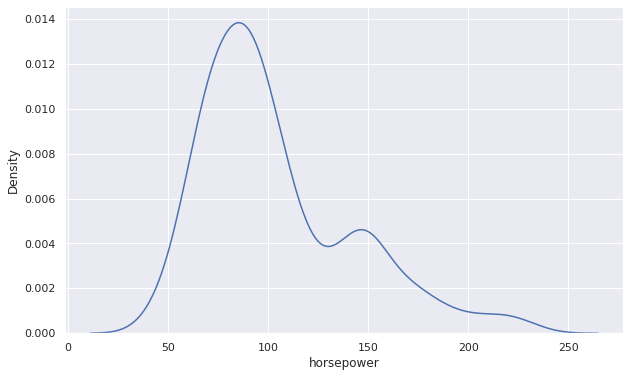

There are some missing values: False


In [ ]:
sns.set()
plt.subplots(figsize=(10, 6))
sns.kdeplot(train_df['horsepower'])
plt.show()

print(f'There are some missing values: {train_df.isna().any().any()}')

When we look at figure below we notice there is some degree of relation between some of the features by just looking it.

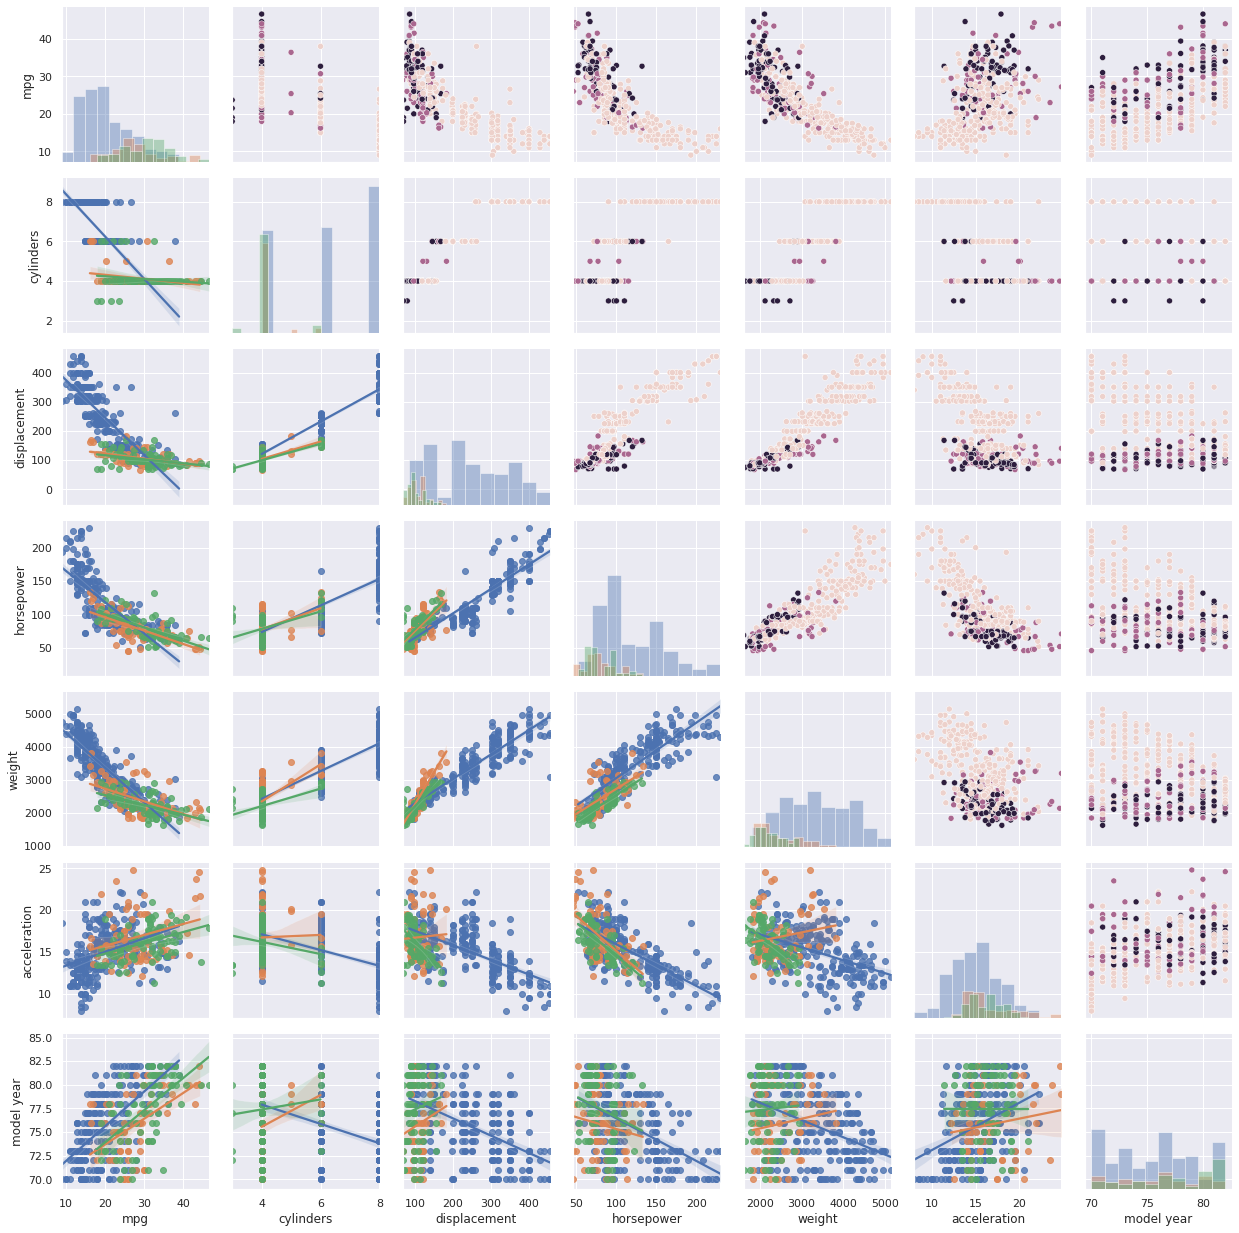

In [ ]:
g = sns.PairGrid(train_df.drop('car name',axis=1), hue='origin')
g = g.map_diag(plt.hist, alpha=0.4)
g = g.map_upper(sns.scatterplot)
g = g.map_lower(sns.regplot)

In [ ]:
org=train_df.copy()
org['origin']=train_df.origin.map({1: 'US', 2: 'Asian',3:'European'})
org['origin'].value_counts(normalize=True)

US          0.625628
European    0.198492
Asian       0.175879
Name: origin, dtype: float64

From this boxplot we can easily see that US manufactured cars are least efficent in terms of mpg and they are almost below global average. It might mean nothing though, we need to move on:


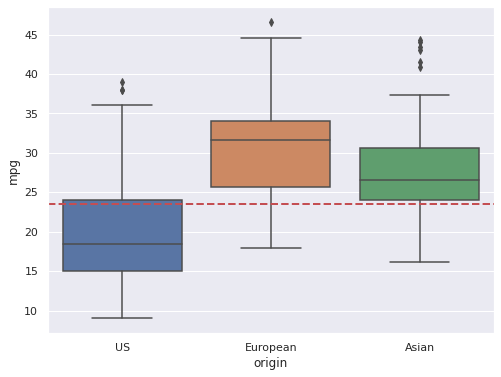

In [ ]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='origin', y="mpg", data=org)
plt.axhline(org.mpg.mean(),color='r',linestyle='dashed',linewidth=2)
plt.show()

Our heatmap confirms there is some kind of linear relation between these features. Let's see if we can catch this trend with our regression models. We'll be there soon...


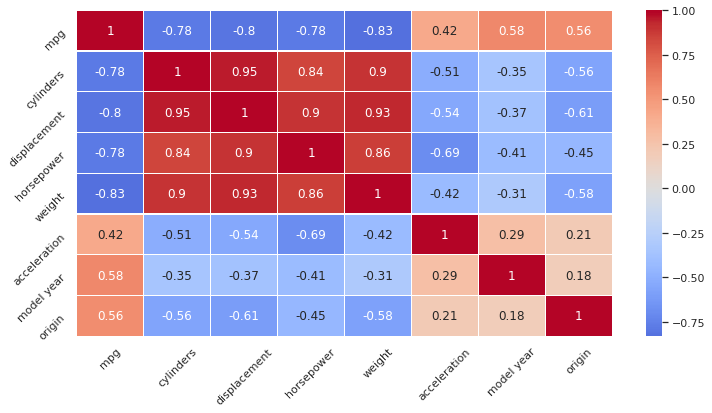

In [ ]:
plt.figure(figsize=(12,6)) 
sns.heatmap(train_df.corr(),annot=True, linewidths=0.2,cmap='coolwarm', center=0) 
plt.xticks(rotation=45) 
plt.yticks(rotation=45) 
plt.show()

Data Processing & Feature Engineering

Before we move on to build our regression models we might take something out of car names feature instead of just dropping them.

It looks like our database has the car brands in first words of our car name column, can we extract this out for searching relations between them?


In [ ]:
pd.crosstab(train_df['car name'],train_df['origin']).describe()

origin,1,2,3
count,305.000000,305.000000,305.000000
mean,0.816393,0.229508,0.259016
std,0.920737,0.531676,0.619151
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,6.000000,4.000000,5.000000


In [ ]:
train_df['Brand'] = train_df['car name'].str.extract('([A-Za-z]+)\s', expand=False)

Our dataset has some typos and duplicate names for some brands, we must replace them before we proceed.


In [ ]:
train_df['Brand']= train_df['Brand'].replace(np.NaN, 'subaru')
train_df['Brand']= train_df['Brand'].replace('chevroelt', 'chevrolet')
train_df['Brand']= train_df['Brand'].replace('vw', 'volkswagen')
train_df['Brand']= train_df['Brand'].replace('toyouta', 'toyota')
train_df['Brand']= train_df['Brand'].replace('vokswagen', 'volkswagen')
train_df['Brand']= train_df['Brand'].replace('maxda', 'mazda')
train_df['Brand']= train_df['Brand'].replace('mazada', 'mazda')
train_df['Brand']= train_df['Brand'].replace('chevy', 'chevrolet')

train_df['Brand'].value_counts(normalize=True)

ford          0.128141
chevrolet     0.118090
plymouth      0.077889
dodge         0.070352
amc           0.070352
toyota        0.065327
datsun        0.057789
volkswagen    0.055276
buick         0.042714
pontiac       0.040201
honda         0.032663
mazda         0.030151
mercury       0.027638
oldsmobile    0.025126
fiat          0.020101
peugeot       0.020101
audi          0.017588
chrysler      0.015075
volvo         0.015075
renault       0.012563
saab          0.010050
subaru        0.010050
opel          0.010050
bmw           0.005025
benz          0.005025
cadillac      0.005025
nissan        0.002513
triumph       0.002513
capri         0.002513
hi            0.002513
mercedes      0.002513
Name: Brand, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


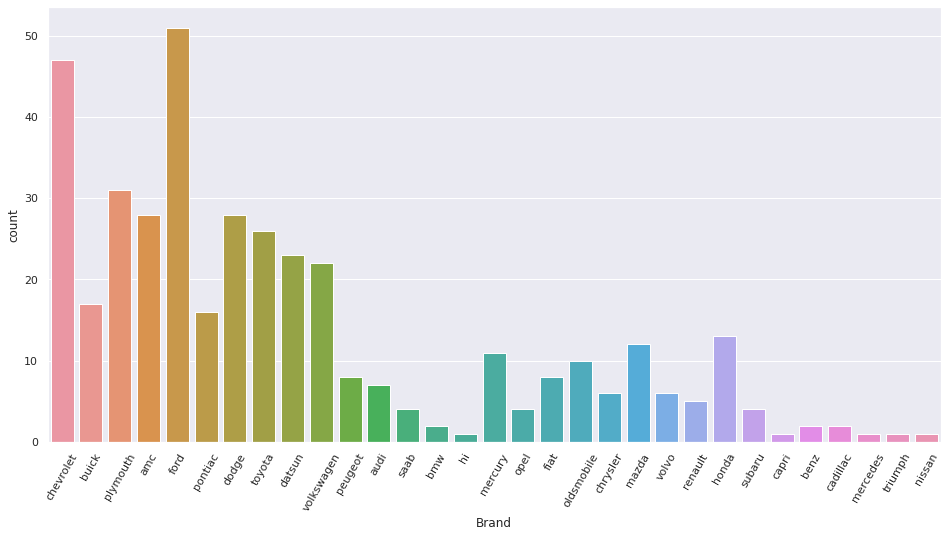

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(train_df['Brand'])
plt.xticks(rotation=60)
plt.show()

It looks much better! It's time to transform these brands to model applicable. We going to categorize them by using sklearn's Label Encoder:


In [ ]:
le = LabelEncoder()
train_df['Brand'] = le.fit_transform(train_df['Brand'])
train_df.drop('car name', axis=1, inplace=True)
train_df.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Brand
367,28.0,4,112.0,88.0,2605,19.6,82,1,7
71,19.0,3,70.0,97.0,2330,13.5,72,3,15
57,24.0,4,113.0,95.0,2278,15.5,72,3,27
382,34.0,4,108.0,70.0,2245,16.9,82,3,27
140,14.0,8,304.0,150.0,4257,15.5,74,1,0


Before building our models last thing I want to check is if our data distribution skewed.

In [ ]:
features=train_df.columns.tolist()
for feature in features:
    print(f'{feature} Skewness: {train_df[feature].skew():.2f}, Kurtosis: {train_df[feature].kurtosis():.2f}')

mpg Skewness: 0.46, Kurtosis: -0.51
cylinders Skewness: 0.53, Kurtosis: -1.38
displacement Skewness: 0.72, Kurtosis: -0.75
horsepower Skewness: 1.11, Kurtosis: 0.75
weight Skewness: 0.53, Kurtosis: -0.79
acceleration Skewness: 0.28, Kurtosis: 0.42
model year Skewness: 0.01, Kurtosis: -1.18
origin Skewness: 0.92, Kurtosis: -0.82
Brand Skewness: 0.22, Kurtosis: -1.03


Can we decrease our skewness with some log scaling? Well little bit better than before.

In [ ]:
skew_cols=['cylinders','displacement','horsepower','weight']
train_df[skew_cols]=np.log1p(train_df[skew_cols])
for feature in features:
    print(f'{feature} skewness: {train_df[feature].skew():.2f}, Kurtosis: {train_df[feature].kurtosis():.2f}')

mpg skewness: 0.46, Kurtosis: -0.51
cylinders skewness: 0.39, Kurtosis: -1.50
displacement skewness: 0.23, Kurtosis: -1.34
horsepower skewness: 0.40, Kurtosis: -0.40
weight skewness: 0.16, Kurtosis: -1.09
acceleration skewness: 0.28, Kurtosis: 0.42
model year skewness: 0.01, Kurtosis: -1.18
origin skewness: 0.92, Kurtosis: -0.82
Brand skewness: 0.22, Kurtosis: -1.03


#Modelling



Let's start with cross validation, then we take a closer look on these models

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
import xgboost as xgb
import lightgbm as lgb

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.drop('mpg', axis=1))
    rmse= np.sqrt(np.abs(cross_val_score(model, train_df.drop('mpg', axis=1).values, train_df['mpg'], scoring="neg_mean_squared_error", cv = kf, n_jobs=-1)))
    return(rmse)

def rtw_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.drop('mpg', axis=1))
    rtw= cross_val_score(model, train_df.drop('mpg', axis=1).values, train_df['mpg'], scoring="r2", cv = kf, n_jobs=-1)
    return(rtw)

Without tuning hyper-paramaters our best option looks like GradientBoostingRegressor, but while in terms of being very close to GBR, XGBRegressor does little bit better on r2 score.


In [ ]:
mods = [LinearRegression(),Ridge(),GradientBoostingRegressor(),
      RandomForestRegressor(),BaggingRegressor(),
      xgb.XGBRegressor(), lgb.LGBMRegressor()]

In [ ]:
model_df = pd.DataFrame({
    'Model': [type(i).__name__ for i in mods],
    'RMSE': [np.mean(rmsle_cv(i)) for i in mods],    
    'Rmse Std': [np.std(rmsle_cv(i)) for i in mods],
    'R2': [np.mean(rtw_cv(i)) for i in mods],
    'R2 Std': [np.std(rmsle_cv(i)) for i in mods]})

display(model_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True).style.background_gradient(cmap='summer_r'))


,Model,RMSE,Rmse Std,R2,R2 Std
0,GradientBoostingRegressor,2.738159,0.955077,0.779933,0.968239
1,XGBRegressor,2.749040,0.922898,0.780117,0.922898
2,LGBMRegressor,2.792823,1.048211,0.763523,1.048211
3,RandomForestRegressor,2.858051,1.087523,0.756529,1.083597
4,BaggingRegressor,3.005093,1.181143,0.710982,1.055154
5,LinearRegression,3.571845,0.956566,0.630390,0.956566
6,Ridge,3.588482,0.996708,0.625087,0.996708


I'm also going to do ta train test split to take a closer look on models and check feature importances on different models.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop('mpg', axis=1),train_df['mpg'], test_size= 0.33, random_state=42)

linreg=LinearRegression()
linreg.fit(X_train,y_train)
y_pred=linreg.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print(rmse)
print(r2_score(y_test, y_pred))

2.7398884564782815
0.8695729435801219


In [ ]:
ridge = Ridge()
ridge.fit(X_train,y_train)
y_pred=ridge.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print(rmse)
print(r2_score(y_test, y_pred))

2.754870735982489
0.8681426391403239


In [ ]:
bag_regressor = BaggingRegressor()
bag_regressor.fit(X_train,y_train)
y_predict = bag_regressor.predict(X_test)
rmse_bgr = np.sqrt(mean_squared_error(y_test,y_predict))

rmse=np.sqrt(mean_squared_error(y_test,y_predict))
print(rmse)
print(r2_score(y_test, y_predict))

2.8412555909902464
0.8597436494924446


In [ ]:
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X_train,y_train)
y_predict = gb_regressor.predict(X_test)
rmse_bgr = np.sqrt(mean_squared_error(y_test,y_predict))

rmse=np.sqrt(mean_squared_error(y_test,y_predict))
print(rmse)
print(r2_score(y_test, y_predict))

2.5281579692598943
0.8889521022295326


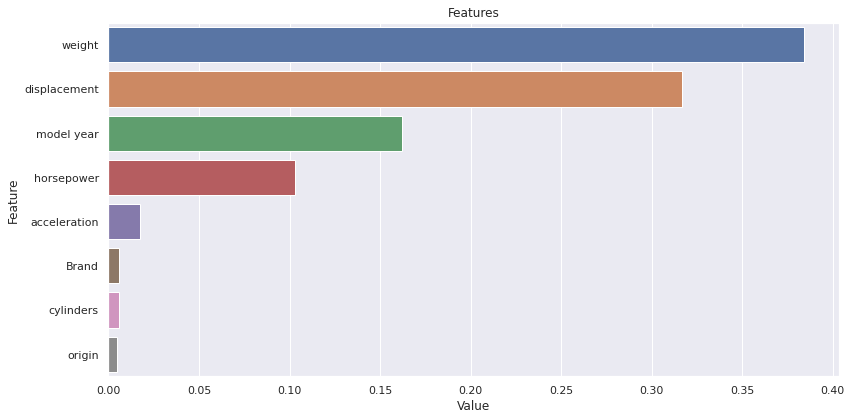

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(gb_regressor.feature_importances_,train_df.drop('mpg', axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train,y_train)
y_predict = rf_regressor.predict(X_test)
rmse_bgr = np.sqrt(mean_squared_error(y_test,y_predict))

rmse=np.sqrt(mean_squared_error(y_test,y_predict))
print(rmse)
print(r2_score(y_test, y_predict))

2.514109195212997
0.890182841924978


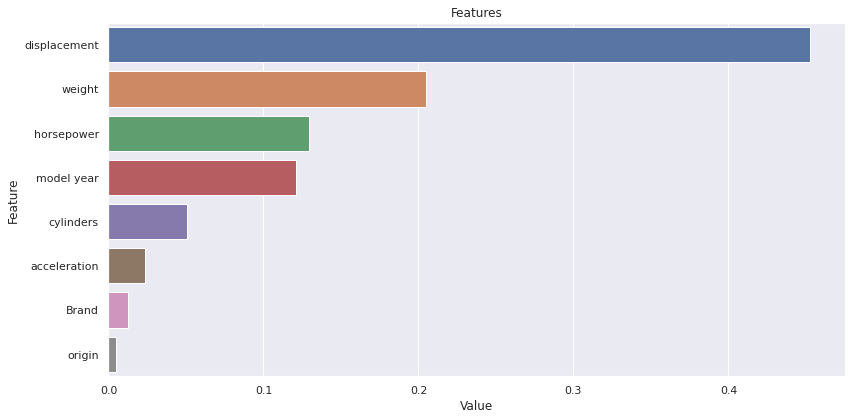

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(rf_regressor.feature_importances_,train_df.drop('mpg', axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

In [ ]:
xg_reg=xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror')

xg_reg.fit(X_train,y_train)
xg_y_pred=xg_reg.predict(X_test)
xg_rmse=np.sqrt(mean_squared_error(y_test,xg_y_pred))
print(xg_rmse)
print(r2_score(y_test,xg_y_pred))

2.6936688321840863
0.8739362186124774


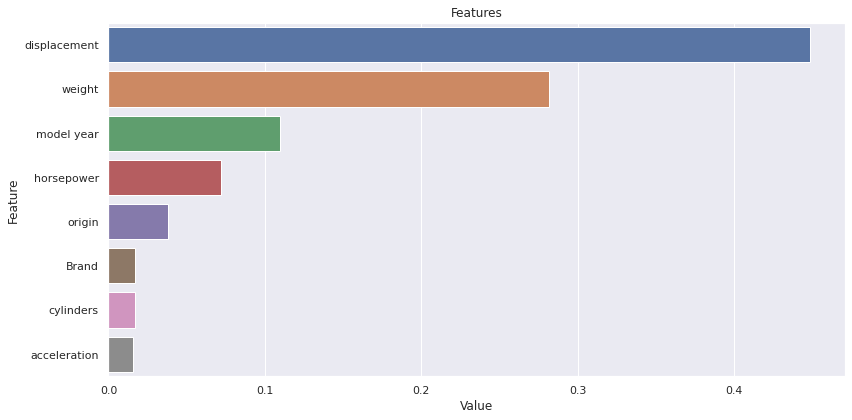

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(xg_reg.feature_importances_,train_df.drop('mpg', axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()

In [ ]:
lgb_reg = lgb.LGBMRegressor()

lgb_reg.fit(X_train,y_train)
y_predict=lgb_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_predict))
print(rmse)
print(r2_score(y_test,y_predict))

2.507874838998369
0.8907268043088836


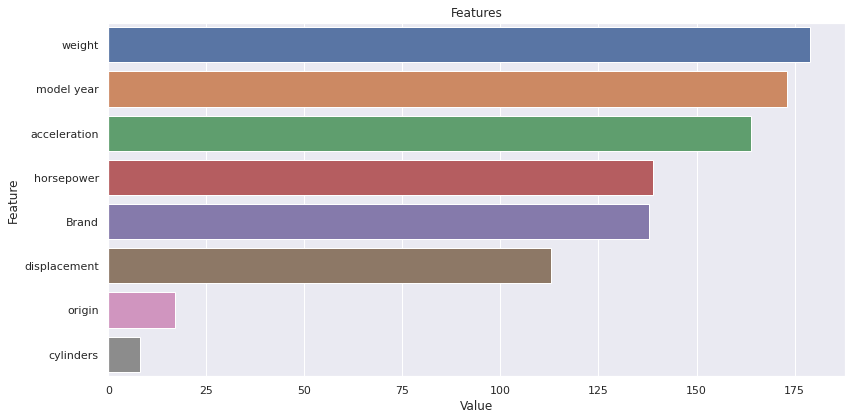

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_,train_df.drop('mpg', axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features')
plt.tight_layout()
plt.show()